# Monte Carlo Prediction

In [97]:
import sys
import gym
import numpy as np
from collections import defaultdict

## BlackJack Environment

```
Simple blackjack environment
Blackjack is a card game where the goal is to obtain cards that sum to as
near as possible to 21 without going over.  They're playing against a fixed
dealer.
Face cards (Jack, Queen, King) have point value 10.
Aces can either count as 11 or 1, and it's called 'usable' at 11.
This game is placed with an infinite deck (or with replacement).
The game starts with each (player and dealer) having one face up and one
face down card.
The player can request additional cards (hit=1) until they decide to stop
(stick=0) or exceed 21 (bust).
After the player sticks, the dealer reveals their facedown card, and draws
until their sum is 17 or greater.  If the dealer goes bust the player wins.
If neither player nor dealer busts, the outcome (win, lose, draw) is
decided by whose sum is closer to 21.  The reward for winning is +1,
drawing is 0, and losing is -1.
The observation of a 3-tuple of: the players current sum,
the dealer's one showing card (1-10 where 1 is ace),
and whether or not the player holds a usable ace (0 or 1).
This environment corresponds to the version of the blackjack problem
described in Example 5.1 in Reinforcement Learning: An Introduction
by Sutton and Barto.
http://incompleteideas.net/book/the-book-2nd.html
```

In [98]:
env = gym.make('Blackjack-v0')

print(vars(env), end='\n\n')
print(dir(env))

{'action_space': Discrete(2), 'observation_space': Tuple(Discrete(32), Discrete(11), Discrete(2)), 'np_random': RandomState(MT19937) at 0x7FA9127EACA8, 'natural': False, 'dealer': [9, 4], 'player': [10, 6], 'spec': EnvSpec(Blackjack-v0)}

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_get_obs', 'action_space', 'close', 'dealer', 'metadata', 'natural', 'np_random', 'observation_space', 'player', 'render', 'reset', 'reward_range', 'seed', 'spec', 'step', 'unwrapped']


In [99]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


In [100]:
random_state = env.reset()
print('Random State', random_state)

random_action = env.action_space.sample()
print('Random Action', random_action)

Random State (13, 10, False)
Random Action 1


## Generate Random Episodes

In [101]:
num_episodes = 5

for i in range(num_episodes):
    print('Episode : ', i+1)
    state = env.reset()
    step = 0
    while True:
        step +=1
        action = env.action_space.sample()
        print('Step = {}\t State = {}\t Action Taken = {}'.format(step, state, action))
        state, reward, done, info = env.step(action)
        if done:
            print('Game Ended...')
            if reward > 0: print('Agent Won!\n')
            else: print('Agent Lost!\n')
            break
    

Episode :  1
Step = 1	 State = (12, 10, False)	 Action Taken = 1
Step = 2	 State = (20, 10, False)	 Action Taken = 0
Game Ended...
Agent Lost!

Episode :  2
Step = 1	 State = (16, 10, False)	 Action Taken = 0
Game Ended...
Agent Lost!

Episode :  3
Step = 1	 State = (20, 10, False)	 Action Taken = 1
Game Ended...
Agent Lost!

Episode :  4
Step = 1	 State = (13, 10, False)	 Action Taken = 0
Game Ended...
Agent Lost!

Episode :  5
Step = 1	 State = (15, 7, True)	 Action Taken = 1
Step = 2	 State = (16, 7, True)	 Action Taken = 0
Game Ended...
Agent Lost!



# Monte Carlo prediction/learning - random action episode
## Control after all episodes

In [102]:
def random_episode_generator(env):
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(2))
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done: break
    return episode

In [103]:
random_episode_generator(env)

[((16, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]

In [104]:
# state-action values matrix/dictionary
Q = defaultdict(lambda: np.zeros(env.action_space.n))

# example states
state0 = 0
state1 = 1
state2 = 2

# action values for each state, set to 0 by default
Q[state0], Q[state1], Q[state2]

(array([0., 0.]), array([0., 0.]), array([0., 0.]))

In [105]:
def mc_prediction(env, num_episodes, generate_episodes, gamma=1.0):
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        episode = generate_episodes(env)
        states, actions, rewards = zip(*episode)
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        for i, state in enumerate(states):
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
    return Q

In [106]:
sample_Q = mc_prediction(env, 5, random_episode_generator)

In [107]:
sample_Q

# need to generate more episodes so that the agents have experienced all possible states 
# and can improve the State-Action table

defaultdict(<function __main__.mc_prediction.<locals>.<lambda>()>,
            {(16, 1, False): array([0., 1.]),
             (21, 1, False): array([1., 0.]),
             (15, 10, False): array([-1.,  0.]),
             (12, 10, False): array([ 0., -1.]),
             (11, 10, False): array([-1.,  0.]),
             (12, 3, False): array([1., 0.])})

In [108]:
Q = mc_prediction(env, 500000, random_episode_generator)

Episode 500000/500000.

In [109]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

## Greedy Policy

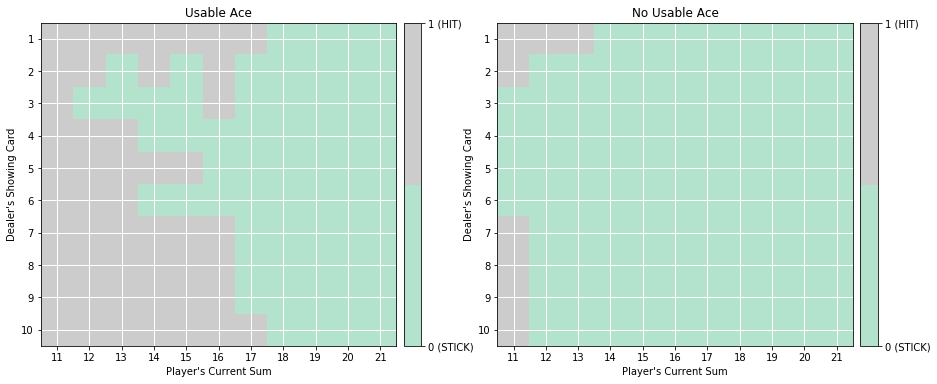

In [110]:
# max policy 
policy = dict((k,np.argmax(v)) for k, v in Q.items())
plot_policy(policy)

## MC Greedy Policy Control after each episode - Exploitation

In [111]:
def generate_episode_from_Q(env, Q, epsilon, nA):
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

def get_probs(Q_s, epsilon, nA):
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s


def mc_prediction(env, num_episodes, generate_episodes, gamma=1.0):
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        nA = env.action_space.n
        episode = generate_episodes(env, Q, 0, nA)
        states, actions, rewards = zip(*episode)
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        for i, state in enumerate(states):
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
    return Q

In [112]:
Q = mc_prediction(env, 500000, generate_episode_from_Q, 0.02)

Episode 500000/500000.

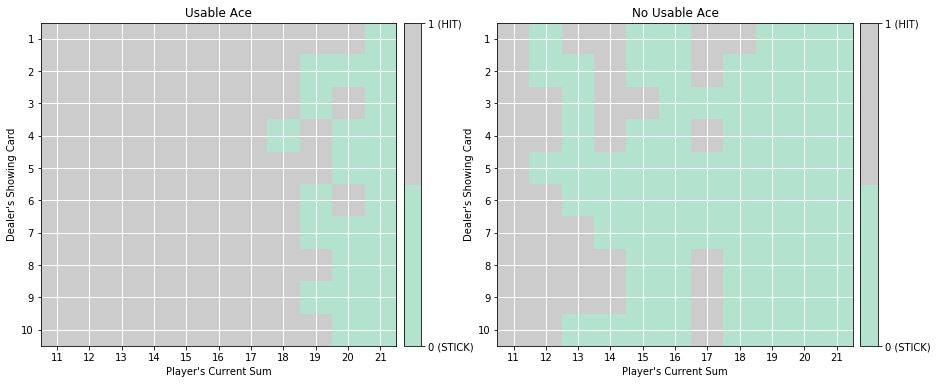

In [113]:
policy = dict((k,np.argmax(v)) for k, v in Q.items())
plot_policy(policy)

## MC epsilon-Greedy Policy Control after each episode - Exploitation with epsilon Exploration

In [114]:
def mc_prediction(env, num_episodes, generate_episodes, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    epsilon = eps_start
    
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        nA = env.action_space.n
        epsilon = max(epsilon*eps_decay, eps_min)
        episode = generate_episodes(env, Q, epsilon, nA)
        states, actions, rewards = zip(*episode)
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        for i, state in enumerate(states):
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
    return Q

In [115]:
Q = mc_prediction(env, 500000, generate_episode_from_Q, 0.02)

Episode 500000/500000.

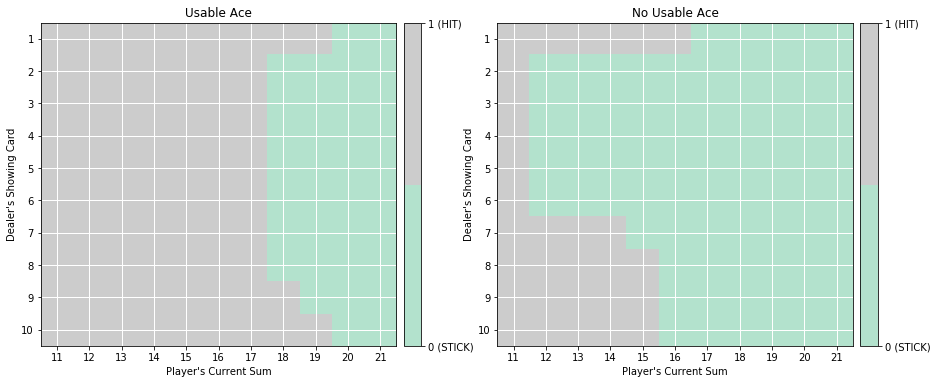

In [116]:
policy = dict((k,np.argmax(v)) for k, v in Q.items())
plot_policy(policy)

## MC epsilon-Greedy Policy Control after each episode with constant alpha incremental mean

In [117]:
def update_Q(env, episode, Q, alpha, gamma):
    states, actions, rewards = zip(*episode)
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q



def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        epsilon = max(epsilon*eps_decay, eps_min)
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        Q = update_Q(env, episode, Q, alpha, gamma)
    return Q


In [118]:
Q = mc_control(env, 500000, 0.02)

Episode 500000/500000.

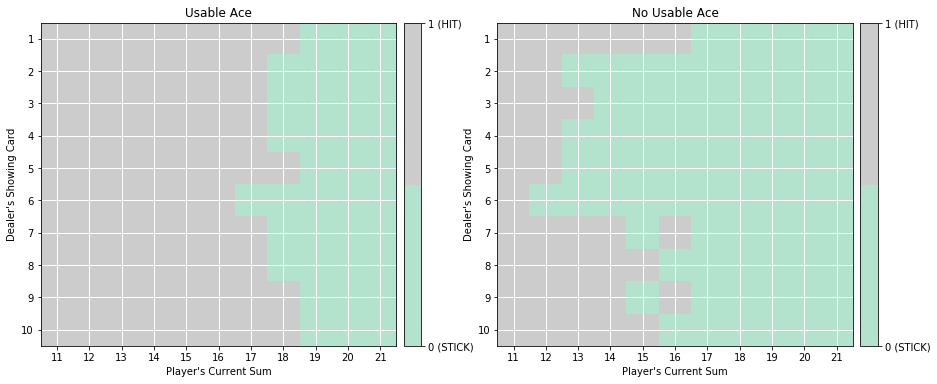

In [119]:
policy = dict((k,np.argmax(v)) for k, v in Q.items())
plot_policy(policy)